## Digital Analyst (CRO) - Project

Description:
The product owner wants to improve the registration journey for mcluck.com users. He has an idea that splitting the manual sign-up form from 1 step to 3 steps will improve the sign-up conversion rate. He is also interested in the impact of this change on purchasing behaviour (first purchase).

## Objectives

To help the product owner make a decision, we need to identify two elements:

> ### First
> To determine the conversion rate, we compare the number of visitors who signed up to the total number of visitors exposed to each variant of the experiment, in both the original and multistep forms.

> ### Second 
> - To find the proportion of first-time purchasers compared to signed-up visitors in both variants.
> - To identify the purchase value in both variants.

### Data
 

Three datasets are available for this analysis as described __[the data description file](CRO_Data Description.pdf)__)__

### Analysis for first objective

Let's do the analysis considering the hypothesis below:

Null Hypothesis (H₀): The null hypothesis states that there is no significant difference between the conversion rate of the two variants of the sign-up forms.  

Alternative Hypothesis (H₁): The alternative hypothesis suggests a significant difference in the conversion rates between the two variants of the sign-up forms.

In [18]:
# Step 1: Importing necessary libraries and loading the datasets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load data into DataFrames (assuming CSV files for this example)
decisions = pd.read_csv('decisions.csv')
conversions = pd.read_csv('conversions.csv')
account_details = pd.read_csv('account_details.csv')


In [20]:
# Filter relevant data
decisions_filtered = decisions[decisions['variation_id'].isin([25991400310, 25974540423])]
conversions_filtered = conversions[conversions['variation_id'].isin([25991400310, 25974540423])]


In [22]:
# Step 2: Analyze Sign-Up Conversion Rate

# Identify sign-up events for both variations as a df
sign_ups = conversions_filtered[conversions_filtered['event_name'] == 'signUp']

# Count unique visitors for each variation
unique_visitors = decisions_filtered.groupby('variation_id')['visitor_id'].nunique()

# Count sign-ups for each variation
sign_up_counts = sign_ups.groupby('variation_id')['visitor_id'].nunique()

# Calculate conversion rates
conversion_rates = sign_up_counts / unique_visitors
print("Signup counts:")
print(sign_up_counts)

print("Counts of unique visitor:")
print(unique_visitors)

print("Conversion Rates:")
print(conversion_rates)

## Variation_id 25991400310 is for the Orignial Form
## Variation_id 25974540423 is for the Orignial Form

Signup counts:
variation_id
25974540423    3934
25991400310    3940
Name: visitor_id, dtype: int64
Counts of unique visitor:
variation_id
25974540423    7642
25991400310    7721
Name: visitor_id, dtype: int64
Conversion Rates:
variation_id
25974540423    0.514787
25991400310    0.510297
Name: visitor_id, dtype: float64


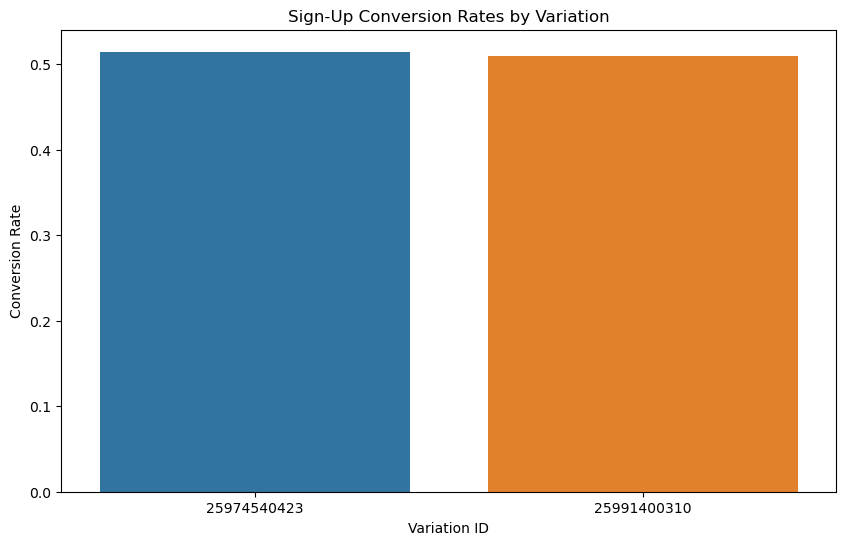

In [24]:
# Plot Conversion Rates
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Sign-Up Conversion Rates by Variation')
plt.xlabel('Variation ID')
plt.ylabel('Conversion Rate')
plt.show()


In [26]:
# Step 4: Statistical Significance (using Chi-Square Test for Proportions)

# Create a contingency table for sign-up conversion rates
contingency_table = pd.DataFrame({
    'sign_ups': sign_up_counts,
    'no_sign_ups': unique_visitors - sign_up_counts
})

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test for Sign-Up Conversion Rate: p-value = {p}")


Chi-Square Test for Sign-Up Conversion Rate: p-value = 0.5888076338966025


A p-value of 0.5888 suggests that there is a high probability that the observed difference (or a more extreme one) could have occurred by random chance alone, assuming that the null hypothesis is true.

### Analysis for the second objective

Let's do the analysis considering the hypothesis below:

Null Hypothesis (H₀): The null hypothesis states that there is no significant difference between the proportion of sign-up counts and first purchase counts for the two variants.  

Alternative Hypothesis (H₁): The alternative hypothesis suggests a significant difference in the conversion rates between the proportion of sign-up counts and first purchase counts for the two variants.

In [28]:
# Merge the two dataframes of conversions and the account details on user_account_id and account_id
merged_df = pd.merge(conversions, account_details, left_on='user_account_id', right_on='account_id')

# Filter for manual sign-up method
filtered_df = merged_df[merged_df['sign_up_method'] == 'manual']

# Further filter for event_name equal to "firstPurchase"
filtered_df = filtered_df[filtered_df['event_name'] == 'firstPurchase']

# Group by variation_id and count the number of firstPurchase events
event_count = filtered_df.groupby('variation_id').size().reset_index(name='firstPurchase_count')

# Group by variation_id and sum the first_purchase_value
total_value = filtered_df.groupby('variation_id')['first_purchase_value'].sum().reset_index(name='total_first_purchase_value')

# Merge sign_up_counts with event_count to calculate the proportion
sign_up_counts = sign_up_counts.reset_index()
proportion_df = pd.merge(sign_up_counts, event_count, on='variation_id')
proportion_df.columns = ['variation_id', 'sign_up_count', 'firstPurchase_count']

# Calculate the proportion of firstPurchase_count to sign_up_counts
proportion_df['proportion'] = proportion_df['firstPurchase_count'] / proportion_df['sign_up_count']

# Print the resulting DataFrame
print(proportion_df)

# Print the resulting firstPurchase_value
print(total_value)

## Variation_id 25991400310 is for the Orignial Form
## Variation_id 25974540423 is for the Orignial Form

   variation_id  sign_up_count  firstPurchase_count  proportion
0   25974540423           3934                  186    0.047280
1   25991400310           3940                  190    0.048223
   variation_id  total_first_purchase_value
0   25974540423                     3023.29
1   25991400310                     2628.19


Plotting the results and testing the significance

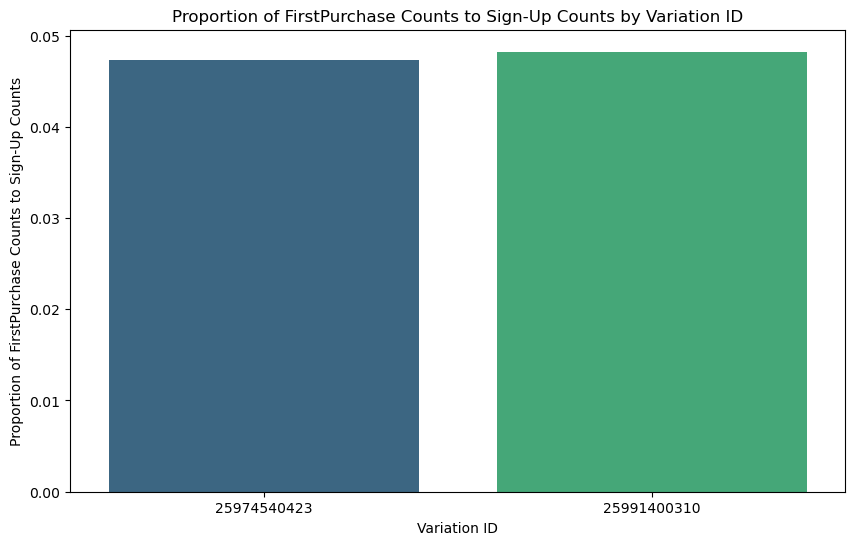

In [30]:

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='variation_id', y='proportion', data=proportion_df, palette='viridis')
plt.xlabel('Variation ID')
plt.ylabel('Proportion of FirstPurchase Counts to Sign-Up Counts')
plt.title('Proportion of FirstPurchase Counts to Sign-Up Counts by Variation ID')
plt.show()


In [32]:
# Conducting a chi-square test of independence to test significance
# Create a contingency table
contingency_table = pd.crosstab(filtered_df['variation_id'], filtered_df['event_name'])

# Perform the chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}, p-value: {p}")

if p < 0.05:
    print("The difference between the variations is statistically significant.")
else:
    print("The difference between the variations is not statistically significant.")


Chi-square statistic: 0.0, p-value: 1.0
The difference between the variations is not statistically significant.


## Conclusion

- Despite the variations in conversion rates between the two variants and the disparities in the proportion of first-purchase counts and sign-up counts, these differences are not statistically significant. This indicates that there is a high probability that the observed difference, or an even more extreme one, could have occurred purely by random chance.
- Recommendation: consider further testing or optimization.